In [230]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [232]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from scipy import stats

import my_functions as func

In [233]:
"""
Load and structure data

"""

# Load data from pickle to dataframe
df = pd.read_pickle("Data/prep_data.pkl")

# Drop irrelevant columns
df = df[['part_name', 'rep', 'char_name', 'error', 'time', 'char_number']]

df.head()

,part_name,rep,char_name,error,time,char_number
0,Leirmo_Exp1_Build3_#11,3,Coaxiality_CC1_8-4,0.115693,2020-07-09 14:20:27,13
1,Leirmo_Exp1_Build3_#11,3,Coaxiality_CC1_16-24,0.029281,2020-07-09 14:20:27,12
2,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_4mm_Pos,0.068728,2020-07-09 14:20:27,10
3,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_8mm_Pos,0.090972,2020-07-09 14:20:27,8
4,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_16mm-Neg,0.098636,2020-07-09 14:20:27,6


---

## Cylindricity, diameter and flatness

---

In [234]:
# Specify characteristics
chars = ['Cylindricity_Cyl_4mm_Pos',
         'Cylindricity_Cyl_8mm_Neg',
         'Cylindricity_Cyl_8mm_Pos',
         'Cylindricity_Cyl_16mm-Neg',
         'Cylindricity_Cyl_16mm_Pos',
         'Cylindricity_Cyl_24mm_Neg',
         'Cylindricity_Cyl_24mm_Pos',
         'Diameter_Cyl_4mm_Pos',
         'Diameter_Cyl_8mm_Neg',
         'Diameter_Cyl_8mm_Pos',
         'Diameter_Cyl_16mm_Neg',
         'Diameter_Cyl_16mm_Pos',
         'Diameter_Cyl_24mm_Neg',
         'Diameter_Cyl_24mm_Pos',
         'Flatness_HX1_Plane1',
         'Flatness_HX1_Plane2',
         'Flatness_HX1_Plane3',
         'Flatness_HX1_Plane4',
         'Flatness_HX1_Plane5',
         'Flatness_HX1_Plane6',
         'Flatness_HX2_Plane1',
         'Flatness_HX2_Plane2',
         'Flatness_HX2_Plane3',
         'Flatness_HX2_Plane4',
         'Flatness_HX2_Plane5',
         'Flatness_HX2_Plane6']

# Define list of strings to simplify column selection
reps = ['rep1', 'rep2', 'rep3']

# Extract characteristics for dataframe
df_s = df[df['char_name'].isin(chars)]

# Split repetitions into separate dataframes
df_r1 = df_s[df_s['rep'] == 1]
df_r2 = df_s[df_s['rep'] == 2]
df_r3 = df_s[df_s['rep'] == 3]

# Sort rows and rename columns to ensure aligned data after merge
df_r1 = df_r1.set_index('part_name').sort_values(by='time').rename(columns={'error': 'rep1', 'char_name': 'char_type'})
df_r2 = df_r2.set_index('part_name').sort_values(by='time').rename(columns={'error': 'rep2', 'char_name': 'char_type'})
df_r3 = df_r3.set_index('part_name').sort_values(by='time').rename(columns={'error': 'rep3', 'char_name': 'char_type'})

# Merge the dataframes (with the different repetitions)
df_tot = pd.concat([df_r1, df_r2['rep2'], df_r3['rep3']], axis=1)

# Drop redundant columns and reset index
df_tot = df_tot[['char_type', 'rep1', 'rep2', 'rep3']].reset_index()

# Calculate mean
df_tot['mean'] = df_tot[reps].mean(axis=1)

# Calculate difference between minimum and maximum
df_tot['diff'] = df_tot[reps].max(axis=1) - df_tot[reps].min(axis=1)


# Replace exact characteristic with simply characteristic type
df_tot.loc[df_tot['char_type'].str.startswith('Cylindricity'), 'char_type'] = 'Cylindricity'
df_tot.loc[df_tot['char_type'].str.startswith('Flatness'), 'char_type'] = 'Flatness'
df_tot.loc[df_tot['char_type'].str.startswith('Diameter'), 'char_type'] = 'Diameter'


# Display top of dataframe
df_tot.head()

,part_name,char_type,rep1,rep2,rep3,mean,diff
0,Leirmo_Exp1_Build1_#16,Flatness,0.090609,0.089763,0.090659,0.090344,0.000896
1,Leirmo_Exp1_Build1_#16,Cylindricity,0.125194,0.123716,0.122998,0.123969,0.002195
2,Leirmo_Exp1_Build1_#16,Cylindricity,0.523211,0.506272,0.492990,0.507491,0.030221
3,Leirmo_Exp1_Build1_#16,Cylindricity,0.208176,0.209331,0.209335,0.208947,0.001159
4,Leirmo_Exp1_Build1_#16,Cylindricity,0.234891,0.230740,0.229380,0.231670,0.005511


<AxesSubplot:xlabel='char_type', ylabel='diff'>

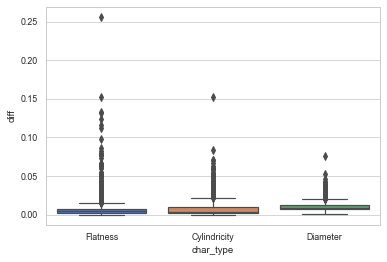

In [235]:
sns.boxplot(data=df_tot, x='char_type', y='diff')

In [236]:
df_tot.describe()

,rep1,rep2,rep3,mean,diff
count,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000
mean,0.088577,0.084998,0.083011,0.085529,0.008634
std,0.122123,0.118936,0.117179,0.119282,0.011865
min,-0.544659,-0.540020,-0.537463,-0.540714,0.000022
25%,0.068541,0.066567,0.065653,0.066977,0.002682
50%,0.090128,0.087218,0.086086,0.087838,0.005521
75%,0.132110,0.127516,0.124374,0.127606,0.009823
max,0.626687,0.576267,0.542467,0.559931,0.256032


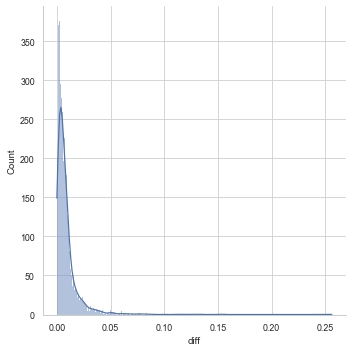

In [237]:
sns.displot(data=df_tot['diff'], kde=True)

<AxesSubplot:ylabel='Frequency'>

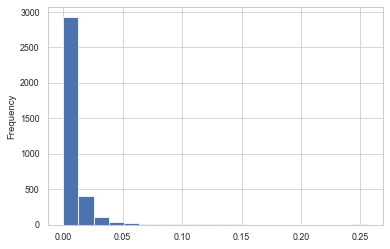

In [238]:
df_tot['diff'].plot.hist(bins=20)

<AxesSubplot:ylabel='diff'>

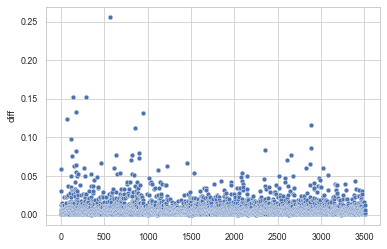

In [239]:
sns.scatterplot(data=df_tot['diff'])

In [240]:
df_tot.describe()

,rep1,rep2,rep3,mean,diff
count,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000
mean,0.088577,0.084998,0.083011,0.085529,0.008634
std,0.122123,0.118936,0.117179,0.119282,0.011865
min,-0.544659,-0.540020,-0.537463,-0.540714,0.000022
25%,0.068541,0.066567,0.065653,0.066977,0.002682
50%,0.090128,0.087218,0.086086,0.087838,0.005521
75%,0.132110,0.127516,0.124374,0.127606,0.009823
max,0.626687,0.576267,0.542467,0.559931,0.256032


In [241]:
df_tot[df_tot['char_type'] == 'Flatness'].describe()

,rep1,rep2,rep3,mean,diff
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,0.095674,0.092236,0.090478,0.092796,0.007512
std,0.036275,0.032351,0.030264,0.032391,0.013618
min,0.050202,0.048980,0.050167,0.050770,0.000022
25%,0.073965,0.072598,0.071659,0.073202,0.002243
50%,0.085891,0.083702,0.082542,0.084008,0.004110
75%,0.104428,0.101005,0.099895,0.101750,0.007575
max,0.452250,0.379740,0.369438,0.400476,0.256032


In [242]:
df_tot[df_tot['char_type'] == 'Cylindricity'].describe()

,rep1,rep2,rep3,mean,diff
count,945.000000,945.000000,945.000000,945.000000,945.000000
mean,0.168441,0.163762,0.161195,0.164466,0.008281
std,0.090416,0.087664,0.085764,0.087803,0.011988
min,0.061079,0.059637,0.058774,0.060130,0.000037
25%,0.101745,0.098606,0.097388,0.099101,0.001853
50%,0.139948,0.134721,0.133477,0.135979,0.003870
75%,0.209945,0.203902,0.199819,0.204689,0.009673
max,0.626687,0.576267,0.542467,0.559931,0.152833


In [243]:
df_tot[df_tot['char_type'] == 'Diameter'].describe()

,rep1,rep2,rep3,mean,diff
count,945.000000,945.000000,945.000000,945.000000,945.000000
mean,-0.003456,-0.006173,-0.007973,-0.005867,0.010911
std,0.173366,0.168763,0.166170,0.169378,0.007351
min,-0.544659,-0.540020,-0.537463,-0.540714,0.000601
25%,-0.104839,-0.105265,-0.106002,-0.105763,0.006737
50%,-0.003160,-0.005236,-0.007362,-0.005159,0.008758
75%,0.100728,0.091944,0.087936,0.093160,0.012221
max,0.552522,0.529453,0.504446,0.519717,0.075344


---

## Filter data

---

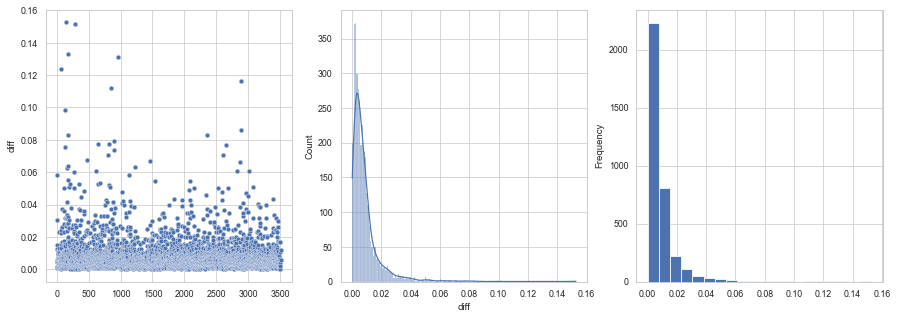

In [244]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

df_1 = df_tot[df_tot['diff'] < df_tot['diff'].max()]

data = df_1['diff']

sns.scatterplot(ax=ax[0], data=data)
sns.histplot(ax=ax[1], data=data, kde=True)
ax[2] = data.plot.hist(bins=20)

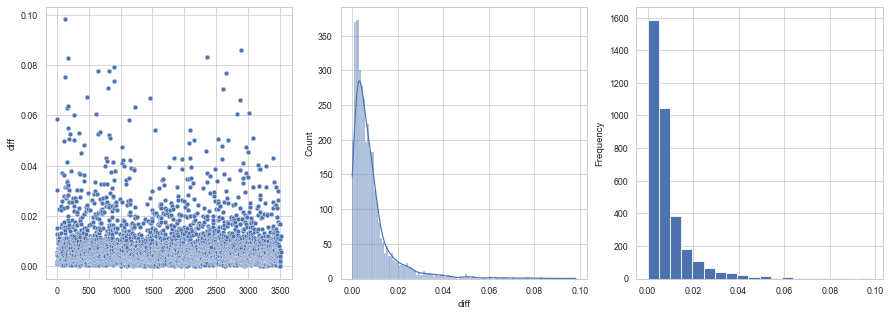

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

df_2 = df_tot[df_tot['diff'] < 0.1]

data = df_2['diff']

sns.scatterplot(ax=ax[0], data=data)
sns.histplot(ax=ax[1], data=data, kde=True)
ax[2] = data.plot.hist(bins=20)

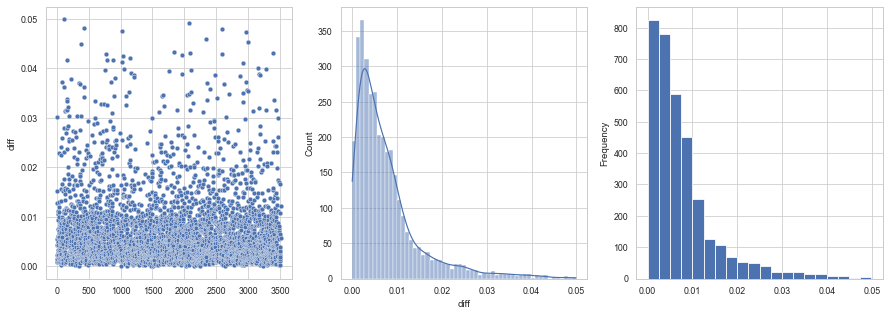

In [246]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

df_3 = df_tot[df_tot['diff'] < 0.05]

data = df_3['diff']

sns.scatterplot(ax=ax[0], data=data)
sns.histplot(ax=ax[1], data=data, kde=True)
ax[2] = data.plot.hist(bins=20)

In [247]:
std = df_tot['diff'].std()

In [248]:
std

0.011864996684660501

In [249]:
std3 = 3*std

std3

0.03559499005398151

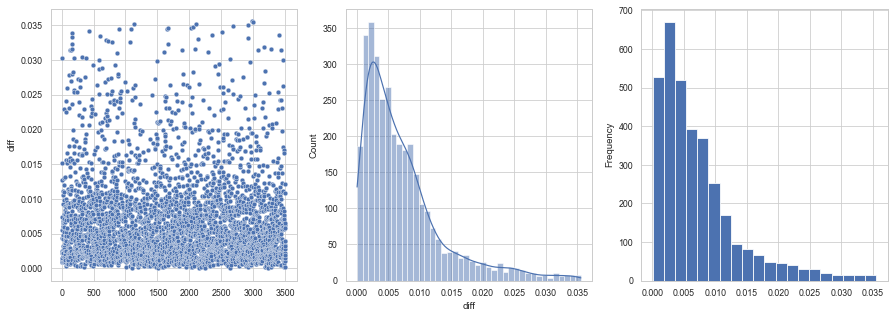

In [250]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

df_4 = df_tot[df_tot['diff'] < std3]

data = df_4['diff']

sns.scatterplot(ax=ax[0], data=data)
sns.histplot(ax=ax[1], data=data, kde=True)
ax[2] = data.plot.hist(bins=20)

In [251]:
len(df_tot)

3510

In [252]:
df_sort = df_tot.sort_values(by='diff', axis=0)

df_sort.reset_index(inplace=True)

df_sort.head()

,index,part_name,char_type,rep1,rep2,rep3,mean,diff
0,2251,Leirmo_Exp1_Build2_#15,Flatness,0.065890,0.065909,0.065912,0.065904,0.000022
1,2635,Leirmo_Exp1_Build3_#14,Cylindricity,0.066940,0.066916,0.066903,0.066920,0.000037
2,3229,Leirmo_Exp1_Build3_#28,Cylindricity,0.136566,0.136615,0.136632,0.136604,0.000065
3,1106,Leirmo_Exp1_Build1_#35,Flatness,0.111123,0.111111,0.111208,0.111147,0.000096
4,1514,Leirmo_Exp1_Build2_#4,Cylindricity,0.073281,0.073175,0.073285,0.073247,0.000109


In [253]:
len(df_sort)

3510

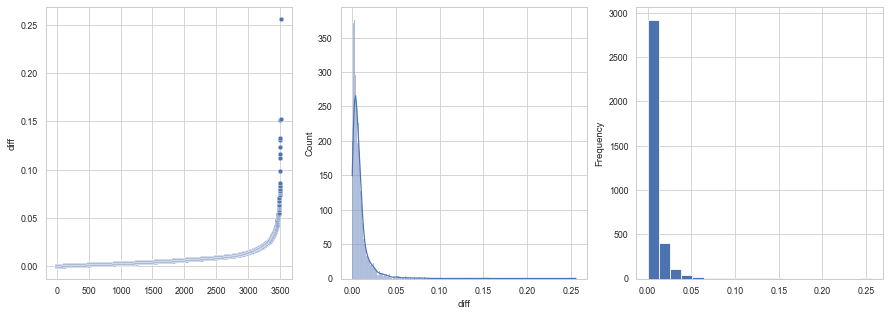

In [254]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

data = df_sort['diff']

sns.scatterplot(ax=ax[0], data=data)
sns.histplot(ax=ax[1], data=data, kde=True)
ax[2] = data.plot.hist(bins=20)

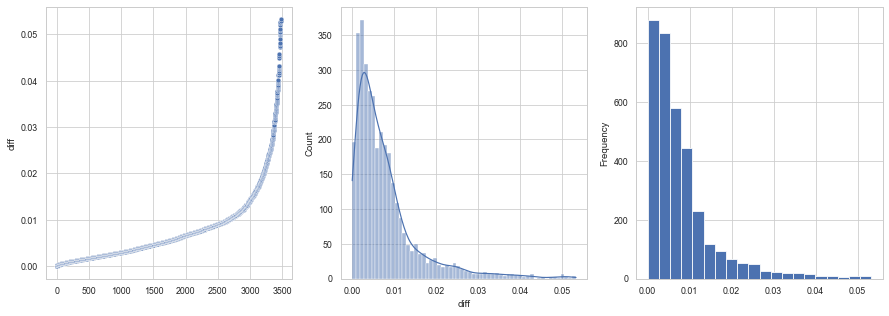

In [255]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

n = round(len(df_sort) * 0.99)

df5 = df_sort.nsmallest(n=n, columns='diff')

data = df5['diff']

sns.scatterplot(ax=ax[0], data=data)
sns.histplot(ax=ax[1], data=data, kde=True)
ax[2] = data.plot.hist(bins=20)

plt.show()

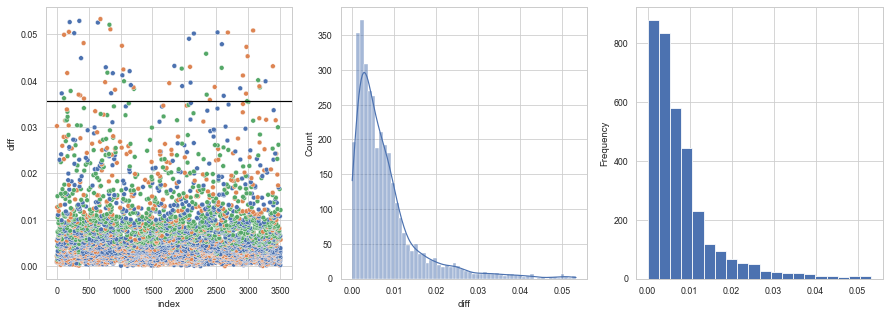

In [256]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

data = df5.set_index('index')

sns.scatterplot(ax=ax[0], data=data, y='diff', x='index', hue='char_type', legend=False)
sns.histplot(ax=ax[1], data=data['diff'], kde=True)
ax[2] = data['diff'].plot.hist(bins=20)

ax[0].axhline(y=std3, color='black')

plt.show()

In [257]:
df_tot.head()

,part_name,char_type,rep1,rep2,rep3,mean,diff
0,Leirmo_Exp1_Build1_#16,Flatness,0.090609,0.089763,0.090659,0.090344,0.000896
1,Leirmo_Exp1_Build1_#16,Cylindricity,0.125194,0.123716,0.122998,0.123969,0.002195
2,Leirmo_Exp1_Build1_#16,Cylindricity,0.523211,0.506272,0.492990,0.507491,0.030221
3,Leirmo_Exp1_Build1_#16,Cylindricity,0.208176,0.209331,0.209335,0.208947,0.001159
4,Leirmo_Exp1_Build1_#16,Cylindricity,0.234891,0.230740,0.229380,0.231670,0.005511


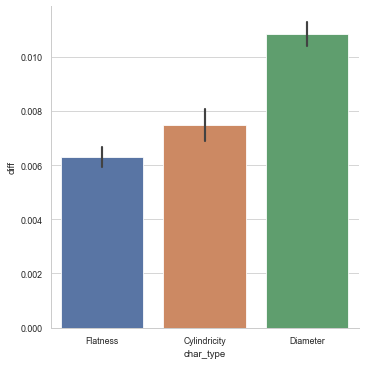

In [258]:
sns.catplot(data=data, kind='bar', x='char_type', y='diff')

In [259]:
df_tot.describe()

,rep1,rep2,rep3,mean,diff
count,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000
mean,0.088577,0.084998,0.083011,0.085529,0.008634
std,0.122123,0.118936,0.117179,0.119282,0.011865
min,-0.544659,-0.540020,-0.537463,-0.540714,0.000022
25%,0.068541,0.066567,0.065653,0.066977,0.002682
50%,0.090128,0.087218,0.086086,0.087838,0.005521
75%,0.132110,0.127516,0.124374,0.127606,0.009823
max,0.626687,0.576267,0.542467,0.559931,0.256032


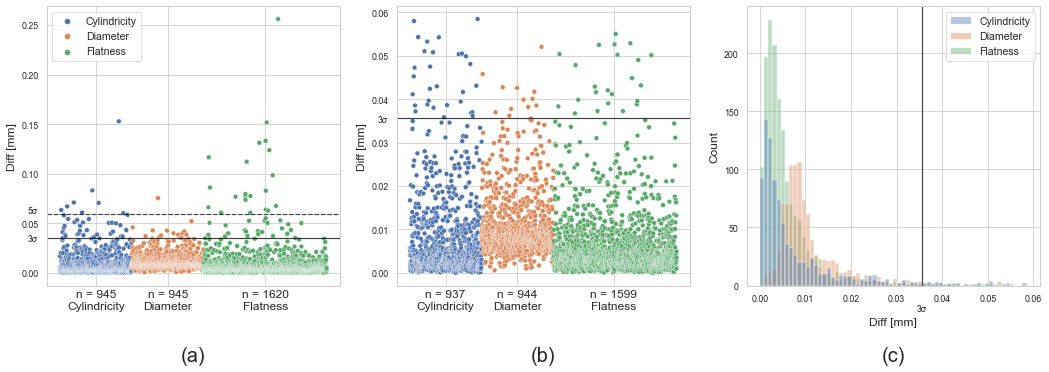

In [260]:
# Definition for font size
small = 12
large = 20

# Initialize figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Configure layout spacing
fig.tight_layout(pad=3.0)

# Set context with Seaborn
sns.set_context("paper", font_scale=1.2)

# Set figure title
#fig.suptitle("Difference between repeated measurements", fontsize='xx-large')

## Prepare data
# Create new dataframe sorted by characteristic type
data = df_tot.sort_values(by='char_type')

# Compute the standard deviation of differences
std = df_tot['diff'].std()

# Reset index
data.reset_index(drop=True, inplace=True)


## PLOT 1
# Scatterplot in first frame
sns.scatterplot(ax=ax[0], data=data, y='diff', x=data.index, hue='char_type', legend=True)

# Insert horizontal line at three standard deviations
ax[0].axhline(y=std*3, color='black', linestyle='-', alpha=0.7)

# Insert horizontal line at five standard deviations
ax[0].axhline(y=std*5, color='black', linestyle='--', alpha=0.7)

# Get number of datapoints for each characteristic
n_cyl = len(data[data['char_type'] == 'Cylindricity'])
n_dia = len(data[data['char_type'] == 'Diameter'])
n_flt = len(data[data['char_type'] == 'Flatness'])

# Set ticks on x-axis in intersections between characteristics
ax[0].set_xticks([n_cyl/2, n_cyl + (n_dia/2), len(data) - (n_flt/2)])

# Set tick labels for x-axis
ax[0].set_xticklabels(["n = {}\nCylindricity".format(n_cyl),\
                       "n = {}\nDiameter".format(n_dia),\
                       "n = {}\nFlatness".format(n_flt)], fontsize=small)

# Hide ticks on x-axis
ax[0].tick_params(axis='x', length=0)

# Set label for y-axis
ax[0].set_ylabel("Diff [mm]", fontsize=small)

# Set ticks on y-axis
ax[0].set_yticks([0, std*3, 0.05, std*5, 0.1, 0.15, 0.2, 0.25])

# Set tick labels for y-axis
ax[0].set_yticklabels(["0.00", "3\u03C3", "0.05", "5\u03C3\n", "0.10", "0.15", "0.20", "0.25"])

# Place legend in upper left corner without title
ax[0].legend(loc='upper left', title=None)

# Add letter below plot
plt.text(x=0.5, y=-0.25, s="(a)", fontsize=large,
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax[0].transAxes)


## Filter outliers above five standard deviations
data = data[data['diff'] < std * 5]


## PLOT 2
# Scatterplot in second frame
sns.scatterplot(ax=ax[1], data=data, y='diff', x=data.index, hue='char_type', legend=False)

# Insert horizontal line at three standard deviations
ax[1].axhline(y=std*3, color='black', linestyle='-', alpha=0.7)

# Get number of datapoints for each characteristic
n_cyl = len(data[data['char_type'] == 'Cylindricity'])
n_dia = len(data[data['char_type'] == 'Diameter'])
n_flt = len(data[data['char_type'] == 'Flatness'])

# Set ticks on x-axis in intersections between characteristics
ax[1].set_xticks([n_cyl/2, n_cyl + (n_dia/2), len(data) - (n_flt/2)])

# Set tick labels for x-axis
ax[1].set_xticklabels(["n = {}\nCylindricity".format(n_cyl),\
                       "n = {}\nDiameter".format(n_dia),\
                       "n = {}\nFlatness".format(n_flt)], fontsize=small)

# Hide ticks on x-axis
ax[1].tick_params(axis='x', length=0)

# Set label for y-axis
ax[1].set_ylabel("Diff [mm]", fontsize=small)

# Set ticks on y-axis
ax[1].set_yticks([0, 0.01, 0.02, 0.03, std*3, 0.04, 0.05, 0.06])

# Set tick labels for y-axis
ax[1].set_yticklabels(["0.00", "0.01", "0.02", "0.03", "3\u03C3", "0.04", "0.05", "0.06"])

# Add letter below plot
plt.text(x=0.5, y=-0.25, s="(b)", fontsize=large,
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax[1].transAxes)


## PLOT 3
# Histogram in third frame
g = sns.histplot(ax=ax[2], data=data, x='diff', hue='char_type', alpha=0.4, kde=False, legend=True)

# Insert Vertical line at three standard deviations
ax[2].axvline(x=std*3, color='black', linestyle='-', alpha=0.7)

# Set label for x-axis
ax[2].set_xlabel("Diff [mm]", fontsize=small)

# Set ticks on x-axis
ax[2].set_xticks([0, 0.01, 0.02, 0.03, std*3, 0.04, 0.05, 0.06])

# Set tick labels for x-axis
ax[2].set_xticklabels(["0.00", "0.01", "0.02", "0.03", "\n3\u03C3", "0.04", "0.05", "0.06"])

# Set label for y-axis
ax[2].set_ylabel("Count", fontsize=small)

# Remove legend title
leg = ax[2].get_legend()
leg.set_title(None)

# Add letter below plot
plt.text(x=0.5, y=-0.25, s="(c)", fontsize=large,
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax[2].transAxes)


# plt.savefig("plots/30_Difference_between_repeated_measurements.jpg", dpi=300, bbox_inches='tight')

## Display plot
plt.show()

In [261]:
data.head()

,part_name,char_type,rep1,rep2,rep3,mean,diff
0,Leirmo_Exp1_Build3_#11,Cylindricity,0.074461,0.069441,0.068728,0.070877,0.005733
1,Leirmo_Exp1_Build2_#19,Cylindricity,0.136517,0.126522,0.119801,0.127614,0.016716
2,Leirmo_Exp1_Build2_#37,Cylindricity,0.124549,0.128611,0.128511,0.127223,0.004062
3,Leirmo_Exp1_Build2_#37,Cylindricity,0.088354,0.087751,0.088842,0.088316,0.001091
4,Leirmo_Exp1_Build2_#37,Cylindricity,0.138155,0.134738,0.133075,0.135323,0.005081


In [262]:
data.describe()

,rep1,rep2,rep3,mean,diff
count,3480.000000,3480.000000,3480.000000,3480.000000,3480.000000
mean,0.087030,0.083914,0.082205,0.084383,0.007915
std,0.121002,0.118323,0.116903,0.118672,0.008185
min,-0.544659,-0.540020,-0.537463,-0.540714,0.000022
25%,0.068263,0.066398,0.065516,0.066856,0.002656
50%,0.089690,0.086909,0.085909,0.087571,0.005467
75%,0.130634,0.126044,0.123671,0.126645,0.009648
max,0.584119,0.553208,0.542467,0.559931,0.058492


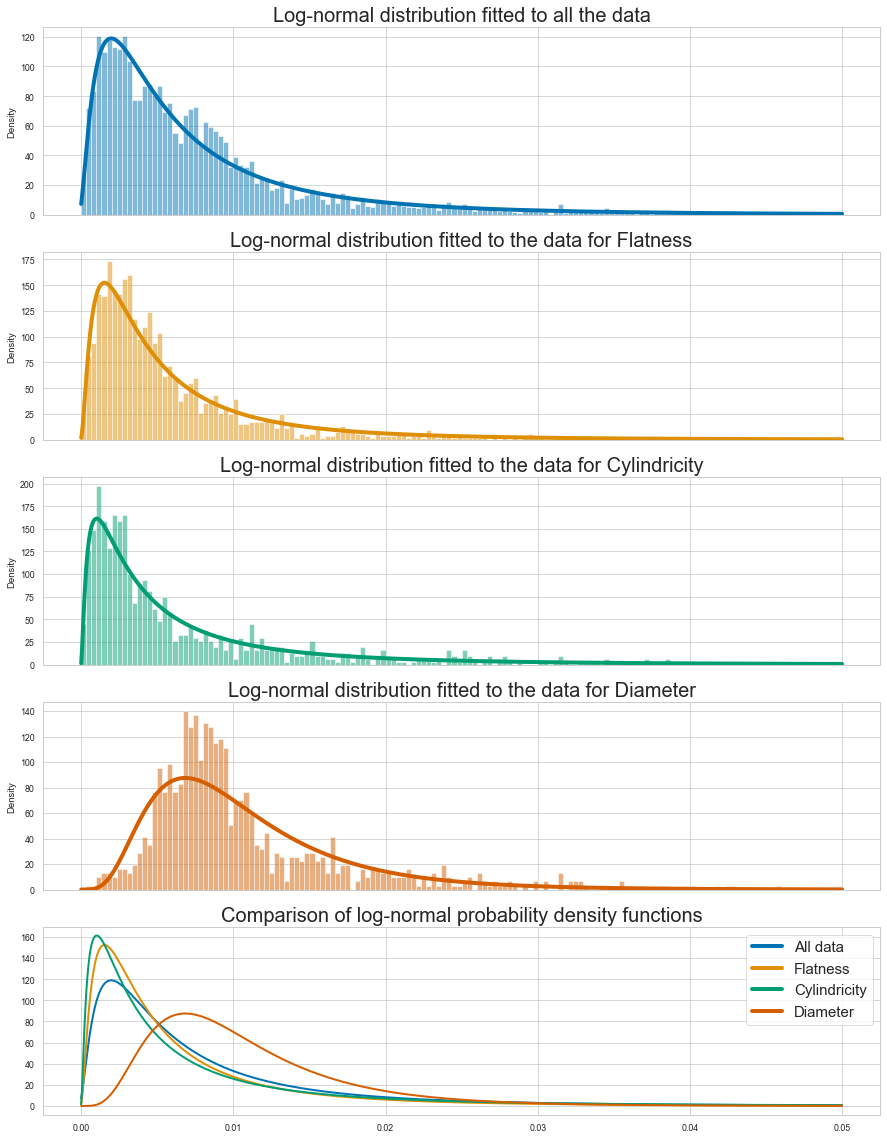

In [270]:
## Define function for retrieving the frozen distribution
#  Valid distribution include lognorm, invgamma and powerlognorm
def calc_pdf(x, data):
    return stats.lognorm.pdf(x, *stats.lognorm.fit(data))


## Set parameters
# Seaborn theme
sns.set_theme(context='paper', style='whitegrid')

# Range for x-axis
xr = 0.05

# Array for x-axis
x = np.linspace(0, xr, 1000)

# Number of bins for histograms
b = 150

# Transperency for histograms
a = 0.5

# Define colors
colors = sns.color_palette('colorblind')

# Define font-sizes
title_s = 20       # Titles
leg_s = 15         # Legend


## Create figure
# Initialize a figure with subplots
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 20), sharex=True)

# Initialize legend
legend_elements = [Line2D([0], [0], color=colors[0], lw=4, label='All data')]

# Find the probability density function for fitted lognormal distribution
pdf = calc_pdf(x, df_tot['diff'])

# Plot the aggregated data
sns.lineplot(x=x, y=pdf, ax=ax[0], linewidth=4, color=colors[0])
sns.lineplot(x=x, y=pdf, ax=ax[4], linewidth=2, color=colors[0])
sns.histplot(df_tot['diff'], stat='density', bins=b, binrange=(0, xr), ax=ax[0], alpha=a, color=colors[0])

# Set details of the plot
ax[0].set_title("Log-normal distribution fitted to all the data", fontsize=title_s)


# Iterate all characteristics and plot them seperately
for char, i in zip(df_tot['char_type'].unique(), range(1, 4)):
    # Find the probability density function for fitted lognormal distribution
    pdf = calc_pdf(x, df_tot.loc[df_tot['char_type'] == char, 'diff'])
    
    # Plot the distribution
    sns.lineplot(x=x, y=pdf, ax=ax[i], linewidth=4, color=colors[i])
    sns.lineplot(x=x, y=pdf, ax=ax[4], linewidth=2, color=colors[i])
    sns.histplot(df_tot.loc[df_tot['char_type'] == char, 'diff'], stat='density', bins=b, binrange=(0, xr), ax=ax[i], color=colors[i], alpha=a)
    
    # Set the details of the plot
    ax[i].set_title("Log-normal distribution fitted to the data for {}".format(char), fontsize=title_s)
    
    legend_elements.append(Line2D([0], [0], color=colors[i], lw=4, label=char))

ax[4].legend(handles=legend_elements, loc='upper right', fontsize=leg_s)
ax[4].set_title("Comparison of log-normal probability density functions", fontsize=title_s)


## Display plot
plt.show()

In [39]:
# Specify characteristics
chars = ['Cylindricity_Cyl_4mm_Pos',
         'Cylindricity_Cyl_8mm_Neg',
         'Cylindricity_Cyl_8mm_Pos',
         'Cylindricity_Cyl_16mm-Neg',
         'Cylindricity_Cyl_16mm_Pos',
         'Cylindricity_Cyl_24mm_Neg',
         'Cylindricity_Cyl_24mm_Pos',
         'Diameter_Cyl_4mm_Pos',
         'Diameter_Cyl_8mm_Neg',
         'Diameter_Cyl_8mm_Pos',
         'Diameter_Cyl_16mm_Neg',
         'Diameter_Cyl_16mm_Pos',
         'Diameter_Cyl_24mm_Neg',
         'Diameter_Cyl_24mm_Pos',
         'Flatness_HX1_Plane1',
         'Flatness_HX1_Plane2',
         'Flatness_HX1_Plane3',
         'Flatness_HX1_Plane4',
         'Flatness_HX1_Plane5',
         'Flatness_HX1_Plane6',
         'Flatness_HX2_Plane1',
         'Flatness_HX2_Plane2',
         'Flatness_HX2_Plane3',
         'Flatness_HX2_Plane4',
         'Flatness_HX2_Plane5',
         'Flatness_HX2_Plane6']

df_rep = df[df['char_name'].isin(chars)]

#df_rep = df_rep.rename(columns={'char_name': 'char_type'})

# Replace exact characteristic with simply characteristic type
#df_rep.loc[df_rep['char_type'].str.startswith('Cylindricity'), 'char_type'] = 'Cylindricity'
#df_rep.loc[df_rep['char_type'].str.startswith('Flatness'), 'char_type'] = 'Flatness'
#df_rep.loc[df_rep['char_type'].str.startswith('Diameter'), 'char_type'] = 'Diameter'

df_rep.head()

,part_name,rep,char_name,error,time,char_number
2,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_4mm_Pos,0.068728,2020-07-09 14:20:27,10
3,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_8mm_Pos,0.090972,2020-07-09 14:20:27,8
4,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_16mm-Neg,0.098636,2020-07-09 14:20:27,6
5,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_24mm_Neg,0.112535,2020-07-09 14:20:27,4
12,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_8mm_Neg,0.066762,2020-07-09 14:20:27,19


In [40]:
df_rep.describe()

,rep,error,char_number
count,10530.000000,10530.000000,10530.000000
mean,2.000000,0.085529,43.384615
std,0.816535,0.119441,21.026765
min,1.000000,-0.544659,4.000000
25%,1.000000,0.066806,19.000000
50%,2.000000,0.087772,49.500000
75%,3.000000,0.128036,62.000000
max,3.000000,0.626687,68.000000


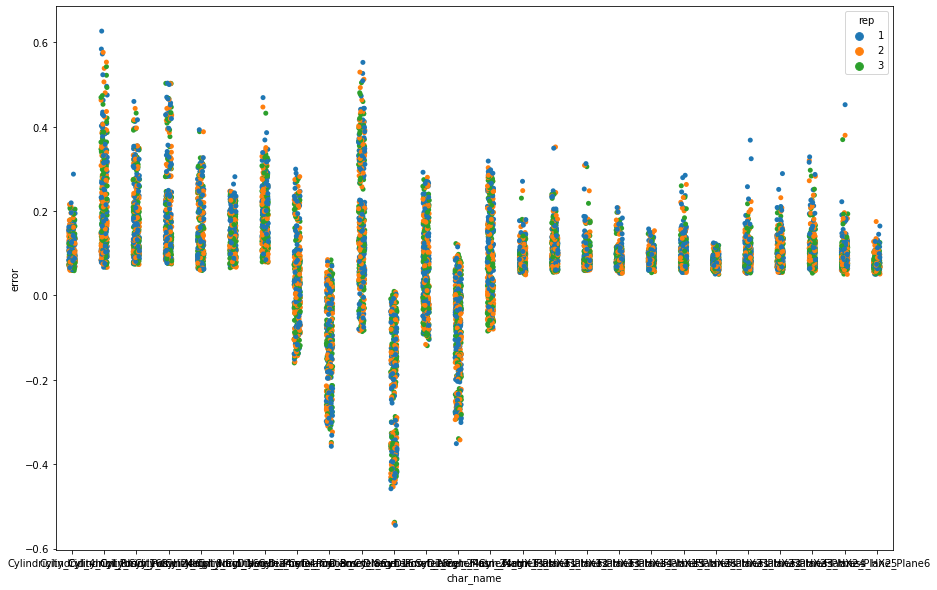

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.stripplot(data=df_rep, x='char_name', y='error', hue='rep', ax=ax)

plt.show()

<AxesSubplot:xlabel='char_type', ylabel='count'>

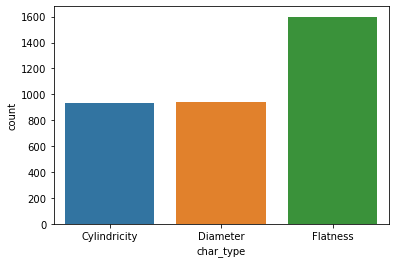

In [42]:
sns.countplot(data=data, x='char_type')

In [43]:
test = df_tot[df_tot['diff'] > std * 3].reset_index(drop=True)

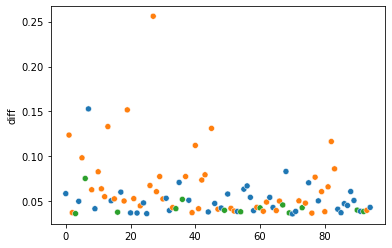

In [44]:
sns.scatterplot(data=test, y='diff', x=test.index, hue='char_type', legend=False)

plt.show()

In [45]:
gb = test.groupby(by='char_type')

In [46]:
gb.head()

,part_name,char_type,rep1,rep2,rep3,mean,diff
0,Leirmo_Exp1_Build1_#16,Cylindricity,0.385966,0.350589,0.327474,0.354676,0.058492
1,Leirmo_Exp1_Build1_#28,Flatness,0.208569,0.118423,0.084883,0.137292,0.123686
2,Leirmo_Exp1_Build1_#28,Flatness,0.117920,0.085334,0.080651,0.094635,0.037269
3,Leirmo_Exp1_Build1_#14,Diameter,0.123355,0.102975,0.087127,0.104486,0.036228
4,Leirmo_Exp1_Build1_#14,Cylindricity,0.198804,0.166437,0.148900,0.171380,0.049903
5,Leirmo_Exp1_Build1_#14,Flatness,0.257911,0.203610,0.159577,0.207032,0.098334
6,Leirmo_Exp1_Build1_#17,Diameter,0.552522,0.529453,0.477177,0.519717,0.075344
7,Leirmo_Exp1_Build1_#17,Cylindricity,0.626687,0.576267,0.473854,0.558936,0.152833
8,Leirmo_Exp1_Build1_#17,Flatness,0.234903,0.181085,0.172142,0.196043,0.062761
9,Leirmo_Exp1_Build1_#8,Cylindricity,0.584119,0.553208,0.542467,0.559931,0.041652


In [47]:
gb.describe()

diff                                                    \
             count      mean       std       min       25%       50%   
char_type                                                              
Cylindricity  38.0  0.051994  0.020296  0.035861  0.039528  0.047820   
Diameter      13.0  0.043701  0.010414  0.036228  0.038237  0.040109   
Flatness      44.0  0.070033  0.041298  0.036741  0.042687  0.053970   

                                  mean              ...         rep2  \
                   75%       max count      mean    ...          75%   
char_type                                           ...                
Cylindricity  0.057095  0.152833  38.0  0.269012    ...     0.333642   
Diameter      0.042770  0.075344  13.0  0.130398    ...     0.194106   
Flatness      0.077991  0.256032  44.0  0.156386    ...     0.181465   

                        rep3                                          \
                   max count      mean       std       min       25%   
char_type                                                              
Cylindricity  0.576267  38.0  0.245198  0.126075  0.082858  0.141420   
Diameter      0.529453  13.0  0.110468  0.140603 -0.029121  0.006035   
Flatness      0.379740  44.0  0.125032  0.064981  0.060267  0.081260   

                                            
                   50%       75%       max  
char_type                                   
Cylindricity  0.213910  0.310171  0.542467  
Diameter      0.075004  0.184431  0.477177  
Flatness      0.101572  0.158245  0.369438  

[3 rows x 40 columns]